# Кредитный скоринг

In [1]:
import pandas as pd
import numpy as np
import scipy

from matplotlib import pyplot as plt
from statsmodels.stats.weightstats import stats, zconfint, _tconfint_generic
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline

In [2]:
data = pd.read_csv('data/credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
def data_preparation(column):
    data0 = data[data['default'] == 0][column]
    data1 = data[data['default'] == 1][column]

    _, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    data0.plot(y=column, kind='hist', color='green', title=column, ax=axes[0], bins = 60)
    data1.plot(y=column, kind='hist', color='red', title=column, ax=axes[1], bins = 60)
    
    return data0.values, data1.values

### Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы

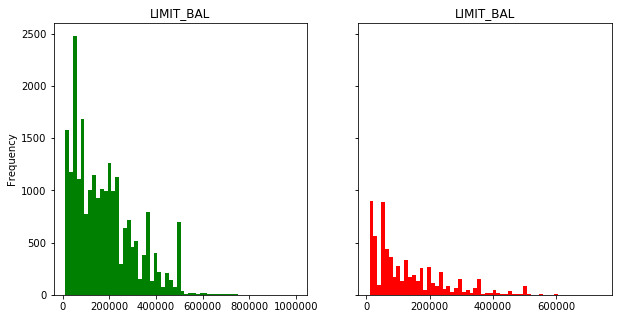

In [4]:
data0, data1 = data_preparation('LIMIT_BAL')

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [6]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

#### Гипотеза о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

In [7]:
np.random.seed(0)

one_median_scores = np.array([np.median(t) for t in get_bootstrap_samples(data1, 1000)])
zero_median_scores = np.array([np.median(t) for t in get_bootstrap_samples(data0, 1000)])

print("95% confidence interval for the data 0 median LIMIT BAL:",  stat_intervals(zero_median_scores, 0.05))
print("95% confidence interval for the data 1 median LIMIT BAL:",  stat_intervals(one_median_scores, 0.05))

95% confidence interval for the data 0 median LIMIT BAL: [ 150000.  150000.]
95% confidence interval for the data 1 median LIMIT BAL: [ 80000.  90000.]


Как можно обратить внимание лимит кредита у людей которые его возвращают значительно выше чем у тех кто нет

In [8]:
print("95% оверительный интервал для разници размеров кредитного лимита", stat_intervals(zero_median_scores - one_median_scores, 0.05))

95% оверительный интервал для разници размеров кредитного лимита [ 60000.  70000.]


Интервал не включает 0, так что мы можем отклонить нулевую гипотезу (о том что медианы выборок совпадают)

#### Гипотеза о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

### 1) Критерий Манна-Уитни
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$
### 2) Перестановочный критерий
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [9]:
stats.mannwhitneyu(data0, data1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)

Значение p-value значительно ниже 0.05 что говорит о том что мы так же можем отклонить нулевую гипотезу (о том что средние значения выборок совпадают)

### Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

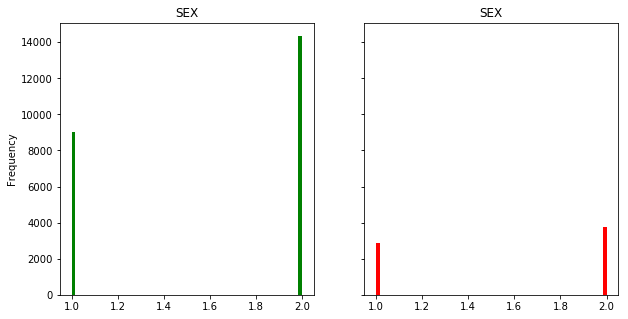

In [10]:
data0, data1 = data_preparation('SEX')

data0 = data0 - 1
data1 = data1 - 1

In [11]:
print('Интервал для пола людей вернувших кредит [%f, %f]' % proportion_confint(np.sum(data0), len(data0)))
print('Интервал для пола людей не вернувших кредит [%f, %f]' % proportion_confint(np.sum(data1), len(data1)))

Интервал для пола людей вернувших кредит [0.607908, 0.620392]
Интервал для пола людей не вернувших кредит [0.555137, 0.578980]


Как видно из доверительного интервала среди людей которые вернули и не вернули кредит преобладает доля женцин.

| $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [12]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [13]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [14]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data0, data1) ))

p-value: 0.000000


Как видно значение p-value очень мало, мы можем с увереностью отвергнуть нулевую гипотезу (о том что гендерный состав людей вернувших и не вернувших кредит отличается) 

### Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

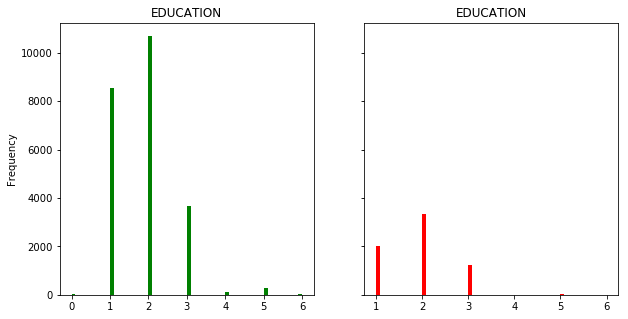

In [15]:
_, _ = data_preparation('EDUCATION')

data0 = data[data['default'] == 0]['EDUCATION']
data1 = data[data['default'] == 1]['EDUCATION']

##### Общее количество

||доктор|магистр|бакалавр|выпускник школы|начальное образование|прочее|нет данных|$$\sum_{}$$|
|--|--|--|--|--|--|--|--|--|
|вернул долг|43|262|116|3680|10700|8549|14|23364|
|не вернул долг|8|18|7|1237|3330|2036|0|6636|

##### Процентное соотношение

||доктор|магистр|бакалавр|выпускник школы|начальное образование|прочее|нет данных|$$\sum_{}$$|
|--|--|--|--|--|--|--|--|--|
|вернул долг|0.18|1.12|0.5|15.75|45.8|36.59|0.06|100|
|не вернул долг|0.12|0.27|0.11|18.64|50.18|30.68|0|100|

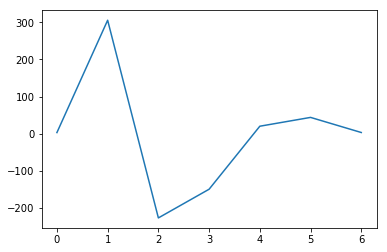

In [16]:
def fill_counts(df):
    for i in range(7):
        if i not in df.index:
            df[i] = 0
            
    return df

data0_counts = fill_counts(data0.value_counts())
data1_counts = fill_counts(data1.value_counts())

temp = [[data0_counts[i], data1_counts[i]] for i in range(7)]
stat = stats.chi2_contingency(temp)[3]
y = (temp - stat)[:, 0]
x = range(7)

_ = plt.plot(x, y)

На получившемся графике (чем больше значение тем лучше) мы видем что хуже всего кредит отдают люди с начальным образованием. С теми кто отдает несколько более сложная ситуация, согласно графику это люди с образованием "прочее", но это достаточно сложно интерпритировать так что я бы отметил "магистров", которые идут на втором месте.

### Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

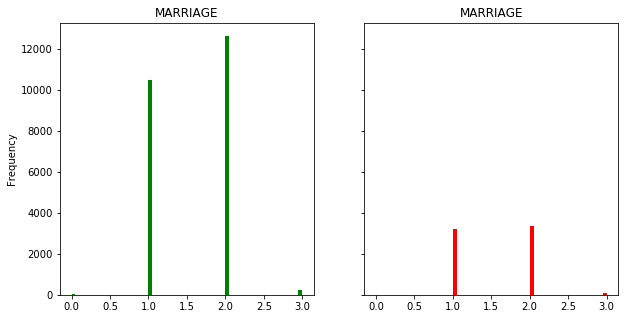

In [17]:
_, _ = data_preparation('MARRIAGE')

Меры, допустимые для проверки взаимосвязи между этими признаками:
$F_1(x_1,x_2) = M(x_1 /x_2=1) - M(x_1 /x_2=0)$
$F_2(x_1,x_2) = Med(x_1 /x_2=1) - Med(x_1 /x_2=0)$

In [18]:
matrix=pd.crosstab(data[['MARRIAGE']].values.T[0],[data[['default']].values.T[0]])

stat, p, _, _ = stats.chi2_contingency(matrix)
corr = np.sqrt(stat ** 2 / data.shape[0])
print('P-value ', p)
print('Correlation ', corr)

P-value  8.82586245758e-08
Correlation  0.205896938349


В соответствии со значением p-value мы можем отклонить H0 (отсутствие связи между признаком MARRIAGE и потенциальным возвратом долга).
Однако учитывая значение кореляции мы можем сказать это эта связь достаточно слабая

### Таблица сопряжоности

In [19]:
matrix

col_0,0,1
row_0,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


### Возраст (AGE)

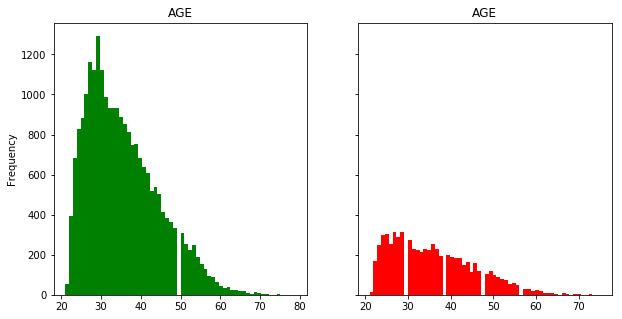

In [20]:
data0, data1 = data_preparation('AGE')

#### Гипотиза о равенстве медианных значений возрастов людей

In [21]:
one_median_scores = np.array([np.median(t) for t in get_bootstrap_samples(data1, 1000)])
zero_median_scores = np.array([np.median(t) for t in get_bootstrap_samples(data0, 1000)])

print("95% confidence interval for the ILEC median repair time:",  stat_intervals(one_median_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  stat_intervals(zero_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [ 34.  35.]
95% confidence interval for the CLEC median repair time: [ 34.  34.]


Гипотеза о равенстве медианных значений возрастов верна

#### Ранговый критерий Манна-Уитни

$H_0\colon F_{d0}(x) = F_{d1}(x)$

$H_1\colon F_{d0}(x) = F_{d1}(x + \Delta), \Delta\neq 0$

In [22]:
stats.mannwhitneyu(data1, data0)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.18625177174493079)

Pvalue имеет достаточно высокое значение, так что H0 не может быть отклонена.

#### Гипотиза о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

$H_0\colon F_{d0}(x) = F_{d1}(x)$

$H_1\colon F_{d0}(x) = F_{d1}(x + \Delta), \Delta\neq 0$

In [23]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [24]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [25]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() for i in indices]
    return distr

In [26]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [27]:
print ("p-value: %f" % permutation_test(data0, data1, max_permutations = 10000))

p-value: 0.017500


Согласно перестановочному критерию гипотиза о равенстве распределений отвергается.

#### Значимы ли полученные результаты с практической точки зрения ?

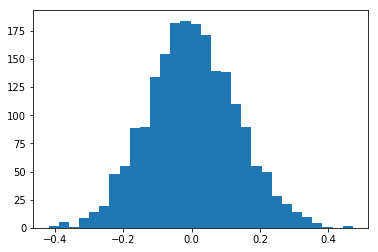

In [28]:
_ = plt.hist(permutation_zero_dist_ind(data0, data1, max_combinations = 2000), bins=30)

Полученые результаты не очень значимы с практической точки зрения, т.к. как можно видеть на гистограмме расброс значений не очень большой